# Churn Modelling with multiple approaches
__Churn Modelling__ : This problem is usually concerned with predicting whether a customer
is going to stay with a company or not. This is very useful financially for companies as it
helps them to target customer groups.

This is typically a binary classification problem. That is you need to look at the data and
predict whether the person will be __exiting(1)__ or the person will __stay(0)__.

In this dataset, we are going to use multiple approaches to this problem of churn modelling

## Initial Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-modelling/Churn_Modelling.csv


In [2]:
# Import the data
data = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv', index_col = 'RowNumber')
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


As we can see, **Exited** is our dependent feature. Other columns are independent features

Let us check how many values of __Exited__ columns are there so that we can figure out if there is class imbalance or not

In [3]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

There are about 8000 examples of '0' and 2000 examples of '1'. This indicates that we have severe class imbalance.
This means that if we have a simple naive classifier that predicts 0 all the time, we can easily achieve 80% accuracy.

So, we need to generate additional synthetic samples for our dataset so that modelling is effective.

## Data Preprocessing
In this step, we are going to preprocess our data so that we can use it on our models.

Preprocessing involves the following:
* Checking for NaN values that is missing values in the data
* Visualise the data so that we can derive meaningful insights
* Split to training and test datasets
* Fill in NaN Values
* Convert non numeric features to numeric features so that we can do predictions
* Scale the data 

Let us go ahead with the first step, __checking for NaN/missing values__

### Checking for Missing Values(NaN)

In [4]:
# check for missing values
data.isnull().any()

CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

Phew! We are lucky we did not get any null values. Usually there are null values in the dataset and we need to remove them

## Data Visualization
Here we are going to plot graphs regarding the data to get a deeper insight.

In [5]:
# Import necessary plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Make figures inline
%matplotlib inline

Let us get a list of columns in the data so that we can predict better. 
We use the .info() method to get the datatypes too

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


**Geography, Gender, Surname** are object data-types, while others are either int / float.

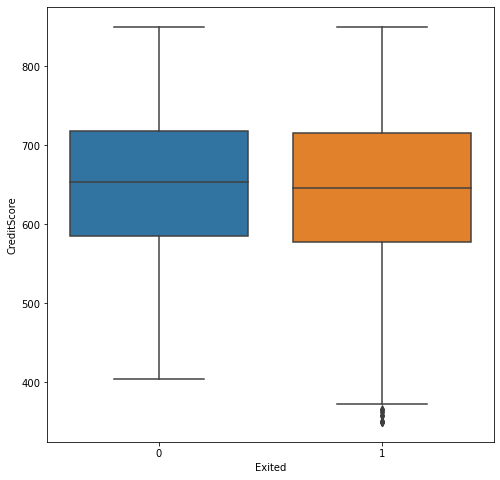

In [7]:
plt.figure(figsize=(8, 8))
sns.boxplot(y = 'CreditScore', x = 'Exited', data = data)

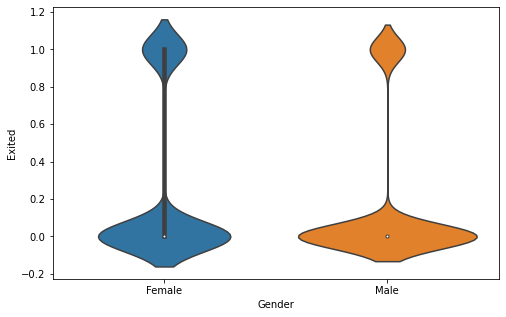

In [8]:
plt.figure(figsize=(8, 5))
sns.violinplot(y = 'Exited' , x = 'Gender' , data = data, kind='boxen')

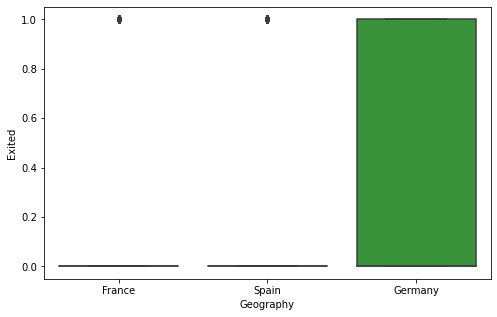

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(y = 'Exited' , x = 'Geography' , data = data)

Let us plot a heatmap of the correlations of the features with each other. That will help us discard non useful features.
It also gives us some idea as to what features predict dependent column best

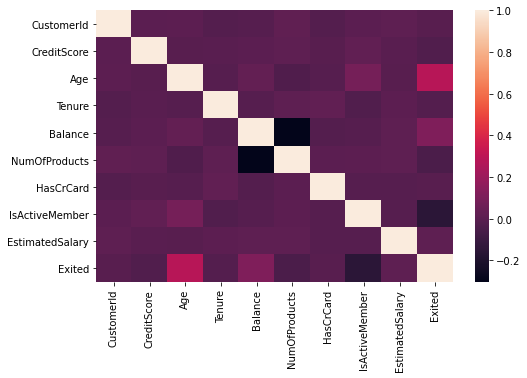

In [10]:
plt.figure(figsize=(8, 5))
sns.heatmap(data.select_dtypes(include='number').corr())

### Converting non numeric features to numeric features
We convert non numeric features to numeric features.
Also we drop columns which do not seem to contribute anything useful like **CustomerId**, **Surname**.

But first we will split the dataset into train and test dataset.

In [11]:
# Drop a useless feature
data.drop(['CustomerId', 'Surname'], axis = 1, inplace = True)

In [12]:
# Get dependent and independent features
X = data.iloc[:, :-1]
y = data.iloc[:, -1].astype('float')
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
3,502,France,Female,42,8,159660.80,3,1,0,113931.57
4,699,France,Female,39,1,0.00,2,0,0,93826.63
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [13]:
# Splitting to train test dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 40)
len(y_train), len(y_val)

(7000, 3000)

In [14]:
# Reset the indexes of the splitted data frames
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [15]:
# Select categorical columns
categorical_cols = [col for col in data.select_dtypes(exclude='number').columns]
categorical_cols

['Geography', 'Gender']

In [16]:
# Label encoder object
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Create two empty data frames
X_train_categorical, X_val_categorical = pd.DataFrame(), pd.DataFrame()

# Label Encode the features
for col in categorical_cols:
    X_train_categorical[col] = label_encoder.fit_transform(X_train[col])
    X_val_categorical[col] = label_encoder.transform(X_val[col])

# Drop the non required columns
X_train.drop(categorical_cols, axis = 1, inplace = True)
X_val.drop(categorical_cols, axis = 1, inplace=True)

# put new colums in dataframe
X_train = X_train.join(X_train_categorical)
X_val = X_val.join(X_val_categorical)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Scale the data

Scaling means to convert the features into a specified range. This helps to make the algorithms converge.
Algorithms like Gradient Descent require Scaling to converge quickly

In [17]:
# import scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Fit and transform training data
X_train = sc.fit_transform(X_train)

#Transform the validation data
X_val = sc.transform(X_val)

In [18]:
y_train.value_counts(), y_val.value_counts()

(0.0    5573
 1.0    1427
 Name: Exited, dtype: int64,
 0.0    2390
 1.0     610
 Name: Exited, dtype: int64)

## Generating new data by oversampling
Since we have an imbalanced dataset, we will increase the number of samples by SMOTE technique

In [19]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek()
# Oversample training  data
X_train, y_train = smk.fit_sample(X_train, y_train)

# Oversample validation data
X_val, y_val = smk.fit_sample(X_val, y_val)

## Final check at the dataset before putting in model
Now we take a final look at the dataset

In [20]:
X_train.shape, X_val.shape

((10972, 10), (4724, 10))

In [21]:
X_train[:5]

array([[-0.62099453, -0.84794096,  1.03327441,  0.77841135,  0.79175325,
        -1.55982545, -1.0354864 , -0.86432413,  1.52346926,  0.91634307],
       [-0.84845207,  0.20265607, -1.04048318, -1.23109531,  0.79175325,
         0.64109738, -1.0354864 ,  0.59666978,  1.52346926,  0.91634307],
       [-1.40675693, -1.32548506,  0.68764814,  0.04910917, -0.91356144,
        -1.55982545,  0.96572973, -1.06856193, -0.89446177, -1.09129433],
       [ 1.29171659, -0.75243213, -0.00360439, -1.23109531,  0.79175325,
         0.64109738, -1.0354864 , -0.12914002, -0.89446177, -1.09129433],
       [-0.11438456,  2.68588541, -0.69485692, -1.23109531, -0.91356144,
        -1.55982545,  0.96572973, -0.99546923, -0.89446177, -1.09129433]])

## Models
We will be using the following models 
* Logistic Regression
* Decision Tree
* Random Forest Classifier
* Extra Trees Classifier
* XGBClassifier
* ANN

In [22]:
# metric
from sklearn.metrics import f1_score

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')

# fit the data
model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_val)

# Get score
f1_score(y_preds, y_val)

0.703404255319149

### Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

# fit the data
model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_val)

# Get score
f1_score(y_preds, y_val)

0.7750958718700653

### Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# fit the data
model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_val)

# Get score
f1_score(y_val, y_preds)

0.8258503401360544

### Extra Trees Classifier

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()

# fit the data
model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_val)

# Get score
f1_score(y_val, y_preds)

0.7981286549707602

In [27]:
from xgboost import XGBClassifier

model = XGBClassifier()

# fit the data
model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_val)

# Get score
f1_score(y_val, y_preds)


0.8937568455640744

## ANN

In [28]:
from tensorflow import keras as K

In [29]:
def lrelu(x):
    return K.activations.relu(x, alpha = 0.01)

In [30]:
model = K.Sequential()

model.add(K.layers.Dense(8, input_dim = 10, activation = lrelu))
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Dense(8, activation = lrelu))
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Dense(4, activation = lrelu))
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Dense(2, activation = lrelu))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1

In [31]:
opt = K.optimizers.Adam(learning_rate = 0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/20
43/43 [==============================] - 0s 7ms/step - loss: 0.6984 - accuracy: 0.5302 - val_loss: 0.6822 - val_accuracy: 0.6080
Epoch 2/20
43/43 [==============================] - 0s 6ms/step - loss: 0.6762 - accuracy: 0.5760 - val_loss: 0.6463 - val_accuracy: 0.6869
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.5941 - val_loss: 0.6294 - val_accuracy: 0.7022
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.6073 - val_loss: 0.6284 - val_accuracy: 0.7066
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.6565 - accuracy: 0.6163 - val_loss: 0.6175 - val_accuracy: 0.7117
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.6204 - val_loss: 0.6158 - val_accuracy: 0.7178
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.6223 - val_loss: 0.6185 - val_accuracy: 0.7110
Epoch 8/20
43/43 [==

In [33]:
opt = K.optimizers.Adam(learning_rate = 0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_val, y_val))

Epoch 1/20
22/22 [==============================] - 0s 7ms/step - loss: 0.6291 - accuracy: 0.6531 - val_loss: 0.5837 - val_accuracy: 0.7424
Epoch 2/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6549 - val_loss: 0.5841 - val_accuracy: 0.7441
Epoch 3/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6582 - val_loss: 0.5826 - val_accuracy: 0.7447
Epoch 4/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6582 - val_loss: 0.5811 - val_accuracy: 0.7458
Epoch 5/20
22/22 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6606 - val_loss: 0.5812 - val_accuracy: 0.7456
Epoch 6/20
22/22 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6580 - val_loss: 0.5800 - val_accuracy: 0.7475
Epoch 7/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6552 - val_loss: 0.5782 - val_accuracy: 0.7466
Epoch 8/20
22/22 [==

In [34]:
y_preds = model.predict_classes(X_val)

In [35]:
f1_score(y_val, y_preds)

0.7544293366295839

## Conclusion
In this notebook, we see XgBoost getting the best results.Neural Network can perform well, but the hyperparameters, model architecture all need to be changed.
I am a beginner and I am still learning.

### Scope for improvement

* Improve ANN architecture
* Tune hyperparameters for Machine Learning Models
* Change optimizer for model
